In [42]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import uuid

## Azure authentication
Don't forget to `az login` in cmd!

In [43]:
keyVaultName = "cvprojectkeyvault"
KVUri = f"https://{keyVaultName}.vault.azure.net"

credential = DefaultAzureCredential()
client = SecretClient(vault_url=KVUri, credential=credential)

In [44]:
FACE_KEY = client.get_secret("faceapikey").value
FACE_ENDPOINT = "https://cvprojectfaceapi.cognitiveservices.azure.com/"

In [45]:
# Create a client
face_client = FaceClient(FACE_ENDPOINT, CognitiveServicesCredentials(FACE_KEY))

In [46]:
face_client.api_version

'1.0'

# Load face images from local files

In [47]:
my_face_images = [file for file in glob.glob('./thumbnails/*.jpg')]
print(my_face_images)

['./thumbnails\\human-face1.jpg', './thumbnails\\human-face2.jpg', './thumbnails\\human-face3.jpg', './thumbnails\\human-face4.jpg', './thumbnails\\human-face5.jpg', './thumbnails\\human-face6.jpg', './thumbnails\\human-face7.jpg', './thumbnails\\human-face8.jpg']


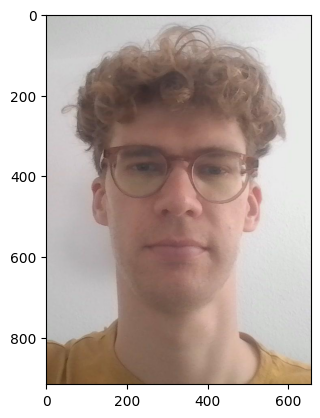

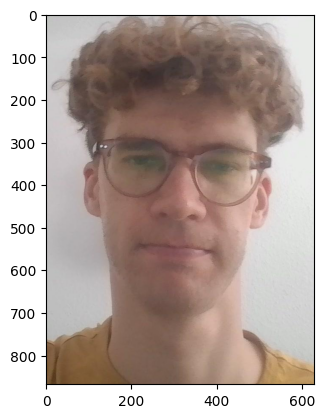

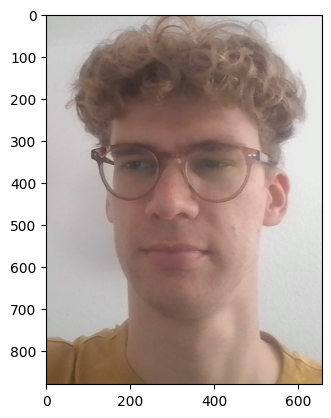

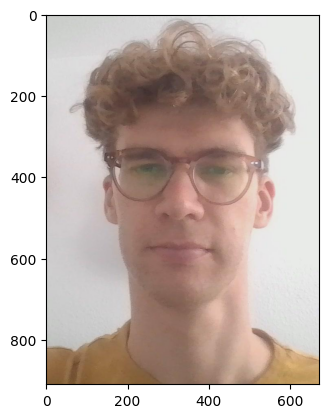

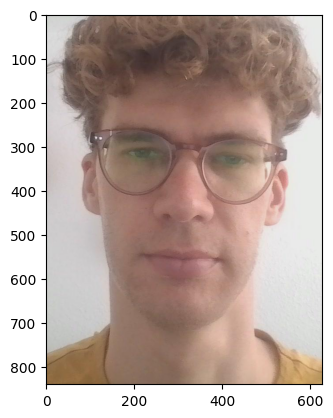

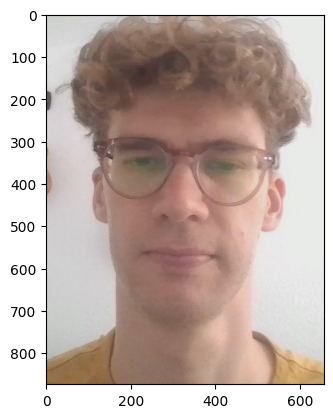

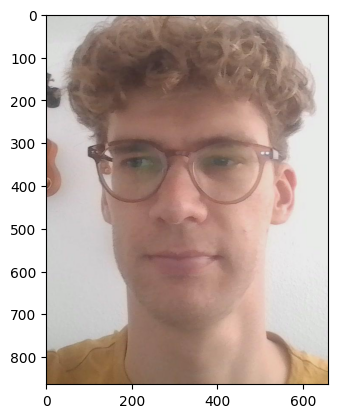

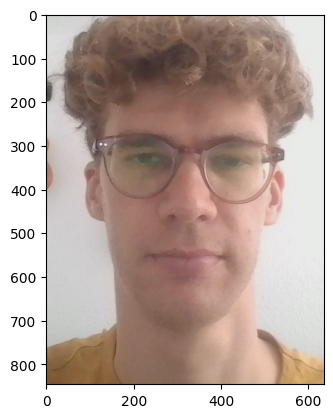

In [48]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure()
        plt.imshow(img_view_ready)

# Create Person model

In [49]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-johannes'

In [50]:
PERSON_GROUP_ID

'8d53b3c7-b56f-4c42-9c77-696c2c5b6a17'

In [51]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id, recognition_model='recognition_03')

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('./thumbnails/*.jpg')]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [52]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 8d53b3c7-b56f-4c42-9c77-696c2c5b6a17


APIErrorException: (InvalidRequest) Invalid request has been sent.